# Titanic - Machine Learning from Disaster: постороение предиктивной модели с использованием ансамбля моделей

Крушение "Титаника" — вероятно, самое известное кораблекрушение в истории. 15 апреля 1912 года во время своего первого рейса, "непотопляемый" Титаник после столкновения с айсбергом пошел ко дну. 1502 человека из 2224 пассижиров корабля (включая команду) погибли. При этом, у определенных групп людей были более высокие шансы выжить.

В этой работе мы попробуем построить модель, которая ответит на вопрос: "кто из пассажиров имел наибольшие шансы на выживание".

**В данной работе используются данные из конкурса Kaggle**. Исходные данные были предобработаны в предыдущем блокноте.

## Загрузка данных

### Импорт библиотек

In [25]:
# модули для работы с данными и визуализации

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# модели

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier


from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

### Загрузка датасета


In [2]:
df = pd.read_csv('data.csv')
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

In [3]:
df.head(10)

,Unnamed: 0,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,1,0.0,3,male,22.0,7.2500,S,1
1,1,2,1.0,1,female,38.0,71.2833,C,1
2,2,3,1.0,3,female,26.0,7.9250,S,0
3,3,4,1.0,1,female,35.0,53.1000,S,1
4,4,5,0.0,3,male,35.0,8.0500,S,0
5,5,6,0.0,3,male,28.0,8.4583,Q,0
6,6,7,0.0,1,male,54.0,51.8625,S,0
7,7,8,0.0,3,male,2.0,21.0750,S,4
8,8,9,1.0,3,female,27.0,11.1333,S,2
9,9,10,1.0,2,female,14.0,30.0708,C,1


В основном датасете, с преобработанными данным образовался пустой признак. От него следует избавиться.

In [4]:
df = df.drop(columns='Unnamed: 0')

### Категориальные данные

В предыдушем блокноте мы применяли модель CatboostClassifier, которая "самостоятельно" справляется с категориальными данными. Для остальных моделей потребуется их преобразование.

In [5]:
data_ohe = pd.get_dummies(df).drop(columns='Sex_female')

In [6]:
data_ohe.head()

,PassengerId,Survived,Pclass,Age,Fare,Family,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,22.0,7.2500,1,1,0,0,1
1,2,1.0,1,38.0,71.2833,1,0,1,0,0
2,3,1.0,3,26.0,7.9250,0,0,0,0,1
3,4,1.0,1,35.0,53.1000,1,0,0,0,1
4,5,0.0,3,35.0,8.0500,0,1,0,0,1


### Обратное разделение данных

Сейчас в датасете собраны данные с тренировчного и тестового наборов, т.к. мы преобразовывали их вместе. Необходимо разделить их. Для тестовых данных отсутствует информация, выжил ли пассажир.

In [7]:
train = data_ohe[data_ohe.PassengerId.isin(train.PassengerId)]
test = data_ohe[data_ohe.PassengerId.isin(test.PassengerId)].drop(columns='Survived', axis=1)

In [8]:
train.tail(5)

,PassengerId,Survived,Pclass,Age,Fare,Family,Sex_male,Embarked_C,Embarked_Q,Embarked_S
884,887,0.0,2,27.0,13.00,0,1,0,0,1
885,888,1.0,1,19.0,30.00,0,0,0,0,1
886,889,0.0,3,28.0,23.45,3,0,0,0,1
887,890,1.0,1,26.0,30.00,0,1,1,0,0
888,891,0.0,3,32.0,7.75,0,1,0,1,0


In [9]:
test.head()

,PassengerId,Pclass,Age,Fare,Family,Sex_male,Embarked_C,Embarked_Q,Embarked_S
889,892,3,34.5,7.8292,0,1,0,1,0
890,893,3,47.0,7.0000,1,0,0,0,1
891,894,2,62.0,9.6875,0,1,0,1,0
892,895,3,27.0,8.6625,0,1,0,0,1
893,896,3,22.0,12.2875,2,0,0,0,1


## Обучение моделей

### Отделение целевого признака

In [46]:
train_target = train['Survived']
train_features = train.drop(['Survived', 'PassengerId'], axis=1)
test_features = test.drop(columns=['PassengerId'])

### Обучение моделей без гиперпараметров

In [21]:
from tqdm import tqdm

In [14]:
kfold = StratifiedKFold(n_splits=10) # стратифицированные выборки для валидации

In [15]:
random_state = 1954 

In [18]:
classifiers = {
    "RF": RandomForestClassifier(random_state=random_state),
    "GB": GradientBoostingClassifier(random_state=random_state),
    "ET":ExtraTreesClassifier(random_state=random_state),
    "KNN": KNeighborsClassifier(), 
    "DT": DecisionTreeClassifier(random_state=random_state),
    "MLP": MLPClassifier(),
    "GNB": GaussianNB(),
    "CB" : CatBoostClassifier(random_state=random_state, verbose =100)
}

 50%|██████████████████████████████████████████                                          | 4/8 [00:04<00:03,  1.15it/s]C:\Users\rizho\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rizho\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rizho\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rizho\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optim

Learning rate set to 0.009366
0:	learn: 0.6870597	total: 1.36ms	remaining: 1.36s
100:	learn: 0.4191310	total: 139ms	remaining: 1.24s
200:	learn: 0.3686794	total: 287ms	remaining: 1.14s
300:	learn: 0.3457656	total: 427ms	remaining: 993ms
400:	learn: 0.3319142	total: 573ms	remaining: 856ms
500:	learn: 0.3179538	total: 720ms	remaining: 717ms
600:	learn: 0.3056561	total: 877ms	remaining: 583ms
700:	learn: 0.2946930	total: 1.04s	remaining: 446ms
800:	learn: 0.2830591	total: 1.21s	remaining: 301ms
900:	learn: 0.2730515	total: 1.36s	remaining: 150ms
999:	learn: 0.2634369	total: 1.51s	remaining: 0us
Learning rate set to 0.009366
0:	learn: 0.6873543	total: 1.3ms	remaining: 1.3s
100:	learn: 0.4294123	total: 158ms	remaining: 1.41s
200:	learn: 0.3804457	total: 329ms	remaining: 1.31s
300:	learn: 0.3588771	total: 478ms	remaining: 1.11s
400:	learn: 0.3440580	total: 625ms	remaining: 934ms
500:	learn: 0.3313234	total: 769ms	remaining: 766ms
600:	learn: 0.3193308	total: 919ms	remaining: 610ms
700:	learn

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:29<00:00,  5.25s/it]

999:	learn: 0.2788982	total: 1.55s	remaining: 0us


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:29<00:00,  3.65s/it]


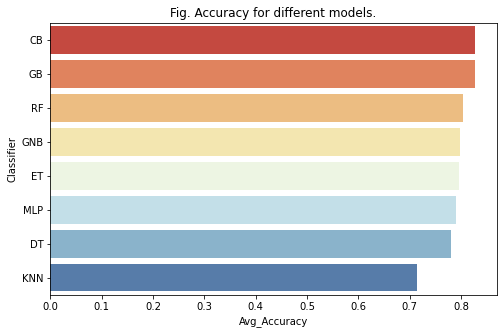

In [23]:
results = pd.DataFrame(columns=["Classifier", "Avg_Accuracy"])
for name, clf in tqdm(classifiers.items()):
    model = clf
    cv_results = cross_validate(model,
                                train_features,
                                train_target,
                                cv=kfold,
                                scoring=(['accuracy', 'f1']))

    results = results.append({
        "Classifier": name,
        "Avg_Accuracy": cv_results['test_accuracy'].mean(),
    }, ignore_index=True)
    
results = results.sort_values("Avg_Accuracy", ascending=False)

fig = plt.figure(figsize = (8,5))
chart = sns.barplot(x="Avg_Accuracy",y="Classifier",data = results, palette = "RdYlBu")
chart.set_title('Accuracy for different models')

plt.show()

Модели с применением градиентного бустинга показали лучшие результаты.

### Настройка моделей

KNN и DT будут нами отброшены как модели с худшими результатами. Для остальных мы переберем гиперпараметры, а затем создадим "процедуру голосования", которой определит к какому классу относится объект.

In [26]:
MLP = MLPClassifier()
MLP_parameters = {'hidden_layer_sizes': [(10,),(20,),(30,)],
                   'activation': ['tanh', 'relu'],
                   'learning_rate': ['constant','adaptive']}

MLP_grid = GridSearchCV(MLP, MLP_parameters, 
                         refit=True,
                        scoring="accuracy",
                        verbose=1,
                        cv=kfold)

MLP_grid.fit(train_features, train_target)

MLP_best = MLP_grid.best_estimator_

print(MLP_grid.best_score_,MLP_grid.best_estimator_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
0.7827757916241062 MLPClassifier(hidden_layer_sizes=(30,))


In [27]:
GNB = GaussianNB()

GNB_param = {'var_smoothing': np.logspace(0,-9, num=100)}

GNB_grid = GridSearchCV(GNB,
                        param_grid = GNB_param,
                        refit= True,
                        scoring="accuracy",
                        verbose = 1,
                        cv=kfold)
GNB_grid.fit(train_features, train_target)


GNB_best = GNB_grid.best_estimator_

print(GNB_grid.best_score_, GNB_grid.best_estimator_)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
0.7987231869254341 GaussianNB(var_smoothing=6.579332246575682e-07)


In [28]:
RF = RandomForestClassifier()

RF_parameters={'bootstrap': [True],
               'max_depth': [1,3,5,7,9,11,13],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [1, 100, 1000]
}

RF_grid = GridSearchCV(RF,
                       RF_parameters,                  
                       refit=True,
                       scoring="accuracy",
                       verbose=1,
                       cv=kfold)

RF_grid.fit(train_features, train_target)

RF_best = RF_grid.best_estimator_

print(RF_grid.best_score_, RF_grid.best_estimator_)

Fitting 10 folds for each of 378 candidates, totalling 3780 fits
0.8357763023493361 RandomForestClassifier(max_depth=13, min_samples_leaf=4)


In [30]:
GBC = GradientBoostingClassifier(random_state=random_state)
GBC_parameters = {'n_estimators':[5,10,50],
                  'learning_rate':[0.01,0.1,1],
                  'random_state': [0,1,2,3]}

GBC_grid = GridSearchCV(GBC, GBC_parameters,
                        refit=True,
                        scoring="accuracy",
                        verbose=1,
                        cv=kfold)

GBC_grid.fit(train_features, train_target)

GBC_best = GBC_grid.best_estimator_

print(GBC_grid.best_score_, GBC_grid.best_estimator_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
0.8278855975485188 GradientBoostingClassifier(n_estimators=50, random_state=0)


In [32]:
CBC = CatBoostClassifier(random_state=random_state, verbose = 100)
CBC_parameters = {'learning_rate': [0.01,0.03, 0.1],
                  'max_depth': [16]}

CBC_grid = GridSearchCV(CBC, CBC_parameters,
                        refit=True,
                        scoring="accuracy",
                        verbose=1,
                        cv=kfold)

CBC_grid.fit(train_features, train_target)

CBC_best = CBC_grid.best_estimator_

Fitting 10 folds for each of 3 candidates, totalling 30 fits
0:	learn: 0.6866502	total: 1.4ms	remaining: 1.4s
100:	learn: 0.3863905	total: 8.86s	remaining: 1m 18s
200:	learn: 0.3132496	total: 24.8s	remaining: 1m 38s
300:	learn: 0.2731392	total: 45.8s	remaining: 1m 46s
400:	learn: 0.2470400	total: 1m 5s	remaining: 1m 38s
500:	learn: 0.2263400	total: 1m 25s	remaining: 1m 24s
600:	learn: 0.2065058	total: 1m 50s	remaining: 1m 13s
700:	learn: 0.1851338	total: 2m 24s	remaining: 1m 1s
800:	learn: 0.1642872	total: 3m 18s	remaining: 49.2s
900:	learn: 0.1466645	total: 4m 13s	remaining: 27.9s
999:	learn: 0.1330277	total: 5m 8s	remaining: 0us
0:	learn: 0.6869637	total: 1.63ms	remaining: 1.63s
100:	learn: 0.3998006	total: 7.55s	remaining: 1m 7s
200:	learn: 0.3287796	total: 23.2s	remaining: 1m 32s
300:	learn: 0.2866217	total: 46.6s	remaining: 1m 48s
400:	learn: 0.2596185	total: 1m 6s	remaining: 1m 39s
500:	learn: 0.2357668	total: 1m 27s	remaining: 1m 27s
600:	learn: 0.2168982	total: 1m 51s	remaining

In [33]:
print(CBC_grid.best_score_, CBC_grid.best_estimator_)

0.8099336057201226 <catboost.core.CatBoostClassifier object at 0x00000190E29D88B0>


In [34]:
CBC_best

In [35]:
GNB_best

GaussianNB(var_smoothing=6.579332246575682e-07)

### Создание процедуры голосования

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:36:39<00:00, 1159.99s/it]


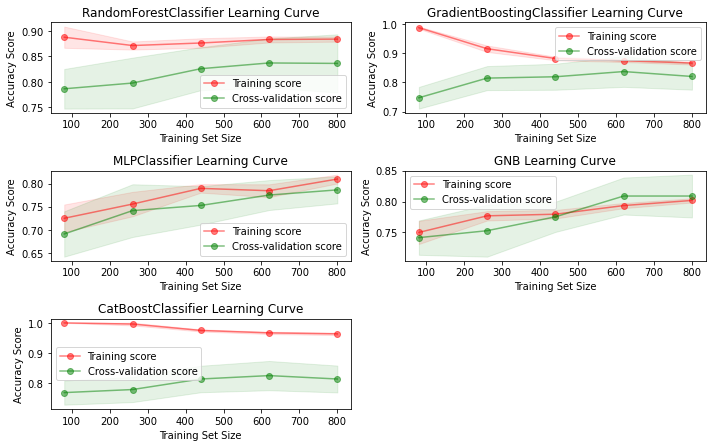

In [36]:
Best_models = {
    "RandomForestClassifier": RF_best,
    "GradientBoostingClassifier": GBC_best,
    "MLPClassifier": MLP_best,
    'GNB': GNB_best,
    'СatBoostClassifier': CBC_best
}

fig = plt.figure(figsize = (10,10))
i = 1

for name, est in tqdm(Best_models.items()):
    
    train_sizes, train_scores, test_scores = learning_curve(est,
                                                            train_features,
                                                            train_target,
                                                            cv=10,
                                                            scoring='accuracy',
                                                            n_jobs=-1,
                                                            train_sizes=np.linspace(0.1, 1.0, 5))
    train_median = np.median(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    test_median = np.median(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    sub = fig.add_subplot(5,2,i)
    plt.plot(train_sizes, train_median, 'o-', color='r', alpha=0.5, label="Training score")
    plt.plot(train_sizes, test_median, 'o-', color='g', alpha=0.5, label="Cross-validation score")
    plt.fill_between(train_sizes, train_median - train_std, train_median + train_std, color='r', alpha=0.1)
    plt.fill_between(train_sizes, test_median - test_std, test_median + test_std, color='g', alpha=0.1)
    plt.title(name + " Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    i += 1

### Голосование

In [47]:
Final_voting = VotingClassifier(estimators=
                           [("RandomForestClassifier", RF_best),
                            ("GradientBoostingClassifier", GBC_best),
                            ("MLPClassifier", MLP_best),
                            ('СatBoostClassifier', CBC_best),
                            ('GNB', GNB_best)],
                            voting='soft',
                            n_jobs=-1,
                            verbose=1)
             
Final_voting = Final_voting.fit(train_features,train_target)

predictions = Final_voting.predict(test_features)

In [49]:
test = pd.read_csv('test.csv')
output_1 = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions.astype(int)})
output_1.to_csv('submission_vote.csv', index=False)

# Результат

Сабмишн дает результат на тестовой выборке 0.77751 проти 0.7751 у константной модели. Улучшение точности на 0.002 далось совсем не просто. Впереди — обучение нейросети.